In [88]:
### install libraries as defined in libraries.py
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from datetime import datetime
import os
from scipy.interpolate import interp1d

#import seaborn as sns
#from sklearn.linear_model import LinearRegression

In [89]:
# Set seed für Reproduzierbarkeit 
seed_number = 1
np.random.seed(seed_number)

We assume that the short term interest rate follows a CIR type process governed by the following set of equations:

$\frac{d\Lambda_t}{\Lambda_t} = - r_t dt + \sigma_\Lambda dz$

$dr_t = \phi (r_t -\bar{r}_t) dt + \sigma_r \sqrt{r_t}dz$

$\bar{r}_t = r^{CB}_t + c$
    
See e.g Chapter 19.4 in Cochrane, J - Asset Pricing (2005).

In [90]:
"""class InterestRateModel:
    def __init__(self, price_of_risk=0.5, conversion_speed=0.5, volatility=0.04, convenience_yield=0.005):
        self.price_of_risk     = price_of_risk
        self.conversion_speed  = conversion_speed
        self.volatility        = volatility
        self.convenience_yield = convenience_yield

    def simulate_path(self, CB_path, r_today = 0.018, steps_per_year=12, time_horizon=20):
        dt = 1.0 / steps_per_year
        T  = int(time_horizon * steps_per_year)
        # r_Bar: sicherstellen, dass len(r_Bar) == T+1
        r_Bar = np.interp(
            np.linspace(0, len(CB_path)-1, T+1),
            np.arange(len(CB_path)),
            CB_path
        ) + self.convenience_yield

        Lambda = np.zeros(T+1)
        Lambda[0] = 1.0

        r = np.zeros(T+1)
        r[0] = r_today

        for t in range(1, T+1):
            Z = np.random.randn()
            r[t] = ( r[t-1]
                     + self.conversion_speed * (r_Bar[t] - r[t-1]) * dt
                     + self.volatility * np.sqrt(max(r[t-1],0)) * np.sqrt(dt) * Z
                   )
            Lambda[t] = ( Lambda[t-1]
                          * np.exp(-r[t-1]*dt
                                   - self.price_of_risk * np.sqrt(dt) * Z
                                   - 0.5 * self.price_of_risk**2 * dt)
                        )

        return r, Lambda
    
    def yield_curve(self, CB_path, steps_per_year=12, time_horizon=20, number_of_simulations = 1000):
        dt = 1.0 / steps_per_year
        time_grid = np.arange(time_horizon * steps_per_year + 1) * dt

        # Pre-allocate
        T = len(time_grid)
        Lambda_paths = np.zeros((number_of_simulations, T))

        # Simulation
        for i in range(number_of_simulations):
            _, Lambda_paths[i, :] = m.simulate_path(
                CB_path=CB_path,
                time_horizon=time_horizon,
                steps_per_year=steps_per_year
            )

        # Erwartungswert (über die Pfade)
        expected_SDF = Lambda_paths.mean(axis=0)
        
        # Yield Curve: nur für t>0 sinnvoll
        yield_curve = np.empty(T)
        yield_curve[0] = np.nan  # oder r[0]
        yield_curve[1:] = -np.log(expected_SDF[1:]) / time_grid[1:]
        
        return yield_curve
"""
        

'class InterestRateModel:\n    def __init__(self, price_of_risk=0.5, conversion_speed=0.5, volatility=0.04, convenience_yield=0.005):\n        self.price_of_risk     = price_of_risk\n        self.conversion_speed  = conversion_speed\n        self.volatility        = volatility\n        self.convenience_yield = convenience_yield\n\n    def simulate_path(self, CB_path, r_today = 0.018, steps_per_year=12, time_horizon=20):\n        dt = 1.0 / steps_per_year\n        T  = int(time_horizon * steps_per_year)\n        # r_Bar: sicherstellen, dass len(r_Bar) == T+1\n        r_Bar = np.interp(\n            np.linspace(0, len(CB_path)-1, T+1),\n            np.arange(len(CB_path)),\n            CB_path\n        ) + self.convenience_yield\n\n        Lambda = np.zeros(T+1)\n        Lambda[0] = 1.0\n\n        r = np.zeros(T+1)\n        r[0] = r_today\n\n        for t in range(1, T+1):\n            Z = np.random.randn()\n            r[t] = ( r[t-1]\n                     + self.conversion_speed * (r_B

In [91]:
import numpy as np

class InterestRateModel:
    def __init__(self, price_of_risk=0.5, conversion_speed=0.5, volatility=0.04, convenience_yield=0.005):
        self.price_of_risk = price_of_risk
        self.conversion_speed = conversion_speed
        self.volatility = volatility
        self.convenience_yield = convenience_yield
    
    def _create_variable_time_grid(self, time_horizon=20, transition_year=15):
        """Create a variable time grid with different step sizes before and after transition_year"""
        times = []
        
        # Phase 1: 4 steps per year until transition_year
        if transition_year > 0:
            phase1_steps = int(transition_year * 4)  # 4 steps per year
            phase1_times = np.linspace(0, transition_year, phase1_steps + 1)
            times.extend(phase1_times[:-1])  # exclude the last point to avoid duplication
        
        # Phase 2: 1 step per year after transition_year
        remaining_years = time_horizon - transition_year
        if remaining_years > 0:
            phase2_steps = int(remaining_years)  # 1 step per year
            phase2_times = np.linspace(transition_year, time_horizon, phase2_steps + 1)
            times.extend(phase2_times)
        else:
            times.append(transition_year)
        
        return np.array(times)
    
    def simulate_path_variable_steps(self, CB_path, r_today=0.018, time_horizon=20, transition_year=15):
        """Simulate with variable time steps"""
        # Create variable time grid
        time_grid = self._create_variable_time_grid(time_horizon, transition_year)
        T = len(time_grid) - 1
        
        # Interpolate CB_path to match our time grid
        r_Bar = np.interp(time_grid, np.linspace(0, time_horizon, len(CB_path)), CB_path) + self.convenience_yield
        
        Lambda = np.zeros(T + 1)
        Lambda[0] = 1.0
        r = np.zeros(T + 1)
        r[0] = r_today
        
        for t in range(1, T + 1):
            dt = time_grid[t] - time_grid[t-1]  # Variable time step
            Z = np.random.randn()
            
            r[t] = (r[t-1] 
                   + self.conversion_speed * (r_Bar[t] - r[t-1]) * dt
                   + self.volatility * np.sqrt(max(r[t-1], 0)) * np.sqrt(dt) * Z)
            
            Lambda[t] = (Lambda[t-1] 
                        * np.exp(-r[t-1] * dt
                               - self.price_of_risk * np.sqrt(dt) * Z
                               - 0.5 * self.price_of_risk**2 * dt))
        
        return r, Lambda, time_grid
    
    def yield_curve_variable_steps(self, CB_path, time_horizon=20, transition_year=15, number_of_simulations=1000):
        """Yield curve calculation with variable time steps"""
        # Get the time grid structure
        time_grid = self._create_variable_time_grid(time_horizon, transition_year)
        T = len(time_grid)
        
        # Pre-allocate
        Lambda_paths = np.zeros((number_of_simulations, T))
        
        # Simulation
        for i in range(number_of_simulations):
            _, Lambda_paths[i, :], _ = self.simulate_path_variable_steps(
                CB_path=CB_path,
                time_horizon=time_horizon,
                transition_year=transition_year
            )
        
        # Expected value (across paths)
        expected_SDF = Lambda_paths.mean(axis=0)
        
        # Yield Curve: only meaningful for t>0
        yield_curve = np.empty(T)
        yield_curve[0] = np.nan  # or r[0]
        yield_curve[1:] = -np.log(expected_SDF[1:]) / time_grid[1:]
        
        return yield_curve, time_grid
    
    def yield_curve(self, CB_path, steps_per_year=12, time_horizon=20, number_of_simulations=1000):
        """Original yield curve method - kept for backward compatibility"""
        dt = 1.0 / steps_per_year
        time_grid = np.arange(time_horizon * steps_per_year + 1) * dt
        
        # Pre-allocate
        T = len(time_grid)
        Lambda_paths = np.zeros((number_of_simulations, T))
        
        # Simulation
        for i in range(number_of_simulations):
            _, Lambda_paths[i, :] = self.simulate_path(
                CB_path=CB_path,
                time_horizon=time_horizon,
                steps_per_year=steps_per_year
            )
        
        # Expected value (across paths)
        expected_SDF = Lambda_paths.mean(axis=0)
        
        # Yield Curve: only meaningful for t>0
        yield_curve = np.empty(T)
        yield_curve[0] = np.nan  # or r[0]
        yield_curve[1:] = -np.log(expected_SDF[1:]) / time_grid[1:]
        
        return yield_curve

Wir probieren nun ein paar Zinspfade zu simulieren.

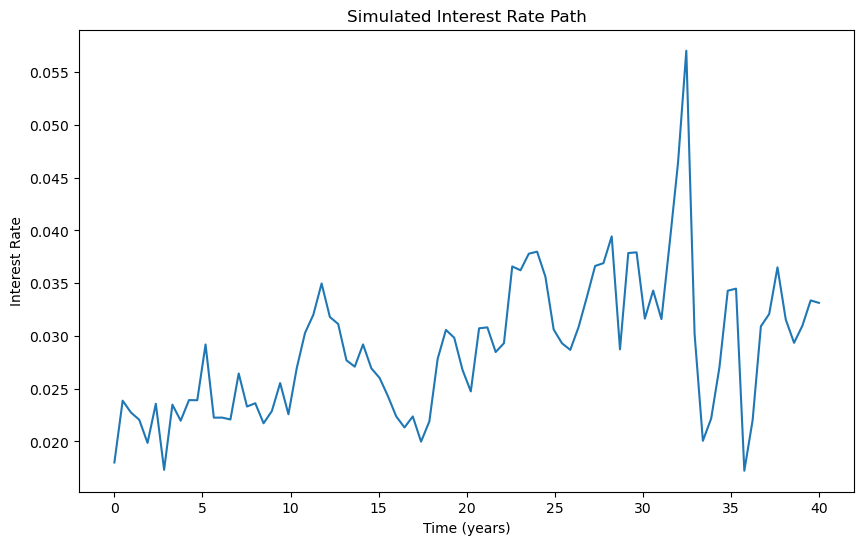

In [92]:
# Modell initialisieren
m = InterestRateModel()
T = 40

# Konstanter Zentralbankpfad
CB_path = np.zeros(T+1) + 0.025

# Simulation
r, Lambda, time_grid = m.simulate_path_variable_steps(
	CB_path=CB_path,
	time_horizon=T,
	transition_year=15
)

# Zeitgitter in Jahren
time_grid = time_grid
time_grid = np.linspace(0, T, len(r))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_grid, r, label='Interest Rate $r_t$')
#plt.plot(time_grid, Lambda/50, label='Discount Factor $\\Lambda_t$')
plt.xlabel('Time (years)')
plt.ylabel('Interest Rate')
plt.title('Simulated Interest Rate Path')
plt.show()

In [93]:
"""# Modell initialisieren
m = InterestRateModel()
T = 40

# Konstanter Zentralbankpfad
CB_path = np.zeros(T+1) + 0.025

# Simulation
r, Lambda = m.simulate_path(
CB_path=CB_path,
time_horizon=T,
)

# Zeitgitter in Jahren
dt = 1.0 / steps_per_year
time_grid = np.linspace(0, T, len(r))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_grid, r, label='Interest Rate $r_t$')
#plt.plot(time_grid, Lambda/50, label='Discount Factor $\\Lambda_t$')
plt.xlabel('Time (years)')
plt.ylabel('Interest Rate')
plt.title('Simulated Interest Rate Path')
plt.show()"""

"# Modell initialisieren\nm = InterestRateModel()\nT = 40\n\n# Konstanter Zentralbankpfad\nCB_path = np.zeros(T+1) + 0.025\n\n# Simulation\nr, Lambda = m.simulate_path(\nCB_path=CB_path,\ntime_horizon=T,\n)\n\n# Zeitgitter in Jahren\ndt = 1.0 / steps_per_year\ntime_grid = np.linspace(0, T, len(r))\n\n# Plot\nplt.figure(figsize=(10, 6))\nplt.plot(time_grid, r, label='Interest Rate $r_t$')\n#plt.plot(time_grid, Lambda/50, label='Discount Factor $\\Lambda_t$')\nplt.xlabel('Time (years)')\nplt.ylabel('Interest Rate')\nplt.title('Simulated Interest Rate Path')\nplt.show()"

We can use this to find long term interest rates. Namely, if the maturity is T, it is given by

$r = - \frac{\log E[\Lambda_T]}{T}$.

The expected value can be resolved by a Monte Carlo simulation.

In [94]:
"""#Yield Curve Berechnung

#Modell initialisieren
m = InterestRateModel()

# Simulation
yield_curve = m.yield_curve(
    CB_path=CB_path,
    time_horizon=T,
    steps_per_year=steps_grid,
    number_of_simulations=10000
)

# Gitter vorbereiten
T = 40
time_grid = np.linspace(0, T, len(yield_curve))

# Plot der Yield-Curve
plt.figure(figsize=(10, 6))
plt.plot(time_grid[4:], yield_curve[4:], label='Yield Curve')
plt.xlabel('Time (years)')
plt.ylabel('Yield')
plt.title('Yield Curve')
plt.legend()
plt.grid(True)
plt.show()"""

"#Yield Curve Berechnung\n\n#Modell initialisieren\nm = InterestRateModel()\n\n# Simulation\nyield_curve = m.yield_curve(\n    CB_path=CB_path,\n    time_horizon=T,\n    steps_per_year=steps_grid,\n    number_of_simulations=10000\n)\n\n# Gitter vorbereiten\nT = 40\ntime_grid = np.linspace(0, T, len(yield_curve))\n\n# Plot der Yield-Curve\nplt.figure(figsize=(10, 6))\nplt.plot(time_grid[4:], yield_curve[4:], label='Yield Curve')\nplt.xlabel('Time (years)')\nplt.ylabel('Yield')\nplt.title('Yield Curve')\nplt.legend()\nplt.grid(True)\nplt.show()"

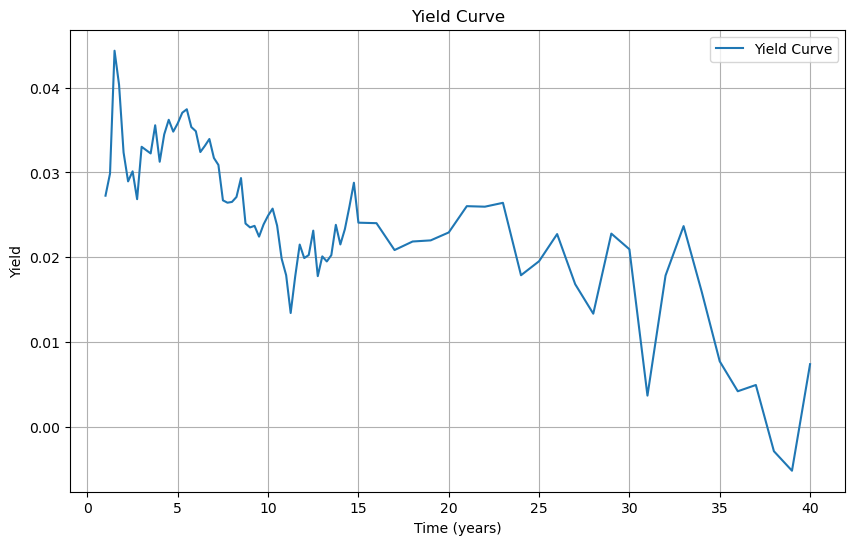

In [95]:
# Simulation
yield_curve, time_grid = m.yield_curve_variable_steps(
    CB_path=CB_path,
    time_horizon=T,
    transition_year=15,
    number_of_simulations=1000
)

# Plot der Yield-Curve
plt.figure(figsize=(10, 6))
plt.plot(time_grid[4:], yield_curve[4:], label='Yield Curve')
plt.xlabel('Time (years)')
plt.ylabel('Yield')
plt.title('Yield Curve')
plt.legend()
plt.grid(True)
plt.show()


Now, let's have a look what happens during an inflation shock. What would Hawks and Doves do?

In [96]:
# Use variable time steps for simulation
T = 40
transition_year = 15

r, Lambda, time_grid = m.simulate_path_variable_steps(
    CB_path=CB_path,
    r_today=0.018,
    time_horizon=T,
    transition_year=transition_year
)

In [97]:
"""m = InterestRateModel()

# Gitter vorbereiten
T = 40*steps_per_year
steps_per_year = 4  ### den Parameter hochschrauben für schönere Graphiken
dt = 1.0 / steps_per_year
time_grid = np.arange(T * steps_per_year + 1) * dt
"""

'm = InterestRateModel()\n\n# Gitter vorbereiten\nT = 40*steps_per_year\nsteps_per_year = 4  ### den Parameter hochschrauben für schönere Graphiken\ndt = 1.0 / steps_per_year\ntime_grid = np.arange(T * steps_per_year + 1) * dt\n'

In [98]:
# Define Taylor Rule 

# Set up Taylor Rule: 
class TaylorRuleParams:
    def __init__(self, a=1.5, b=0.5, pi_star=0.02, y_star=0.0, r_star=0.005):
        self.a = a          # Inflation response coefficient
        self.b = b          # Output gap response coefficient  
        self.pi_star = pi_star  # Target inflation rate
        self.y_star = y_star    # Target output gap
        self.r_star = r_star    # Neutral real interest rate


def calculate_taylor_rate_with_lag(inflation_path, output_gap_path, taylor_params, policy_lag_months=6, steps_per_year=4):
    """
    Calculate central bank rate using Taylor rule with policy lag
    Taylor rule with lag: i_t = r_star + pi_{t-lag} + a*(pi_{t-lag} - pi_star) + b*y_{t-lag}
    
    Parameters:
    - policy_lag_months: Number of months lag in policy response (default 6)
    - steps_per_year: Number of periods per year (default 4 for quarterly data)
    """
    pi = inflation_path
    y = output_gap_path

    # Calculate lag in periods
    lagged_periods = int(policy_lag_months * steps_per_year / 12)

    taylor_rates = np.zeros_like(pi)
    for t in range(len(pi)):
        lagged_period = max(0, t - lagged_periods)
        pi_lagged = pi[lagged_period]
        y_lagged = y[lagged_period]
        taylor_rates[t] = (taylor_params.r_star +
                           pi_lagged +
                           taylor_params.a * (pi_lagged - taylor_params.pi_star) +
                           taylor_params.b * (y_lagged - taylor_params.y_star))
    return taylor_rates


# Define Taylor rule parameters for different scenarios
baseline_params = TaylorRuleParams(a=0.5, b=0.5, pi_star=0.02, y_star=0.0, r_star=0.005)
shock_params = TaylorRuleParams(a=0.5, b=0.5, pi_star=0.02, y_star=0.0, r_star=0.005) 

Now I want to calculate the interest rate path for each scenario. The hawish and doveish interest rates are set with a Taylor rule. The shock scenario adds a shock (+1pp.) on top of the doveish interest rate path which declines over the hiking period. 

In [99]:
# VAR MODEL ADJUSTED
steps_per_year = 4

inflation_baseline = np.concatenate((
    np.array([0.02]),
    np.zeros(int(0.5*steps_per_year)) + 0.05,
    np.zeros(int(0.5*steps_per_year)) + 0.045,   
    np.zeros(int(1*steps_per_year)) + 0.035,
    np.zeros(int(1.5*steps_per_year)) + 0.025,
    np.zeros(int(40*steps_per_year - 3.5*steps_per_year)) + 0.02
))

# Shock scenario inflation 
# CIR-Abnahme im VAR: -0,5 in t=14 für 0,5pp. Shock - 1pp. für 1pp. Shock; 3pp. für 3pp. Shock 

inflation_shock_1pp = np.concatenate((
    np.array([0.02]),
    np.zeros(int(0.5*steps_per_year)) + 0.05,
    np.zeros(int(0.5*steps_per_year)) + 0.045,   
    np.zeros(int(1*steps_per_year)) + 0.03,
    np.zeros(int(1.5*steps_per_year)) + 0.02,
    np.zeros(int(40*steps_per_year - 3.5*steps_per_year)) + 0.020
))

inflation_shock_3pp = np.concatenate((
    np.array([0.02]),
    np.zeros(int(0.5*steps_per_year)) + 0.05,
    np.zeros(int(0.5*steps_per_year)) + 0.045,   
    np.zeros(int(1*steps_per_year)) + 0.015,
    np.zeros(int(1.5*steps_per_year)) + 0.005,
    np.zeros(int(40*steps_per_year - 3.5*steps_per_year)) + 0.020
))

# Output gap paths (assuming zero for simplicity, but can be adjusted)
output_gap_baseline = np.zeros_like(inflation_baseline)
output_gap_shock_1pp = np.zeros_like(inflation_shock_1pp)
output_gap_shock_3pp = np.zeros_like(inflation_shock_3pp)

# Calculation interest rate paths 

# Calculate CB paths using Taylor rule with 6-month policy lag
CB_path_baseline = calculate_taylor_rate_with_lag(inflation_baseline, output_gap_baseline, baseline_params, policy_lag_months=6)

def apply_step_shock(baseline_rates, steps_per_year=12, shock_type='1pp'):
    """
    Apply a step-wise monetary policy shock with specific magnitudes and timing.
    shock_type: '1pp' or '3pp'
    """
    shocked_rates = baseline_rates.copy()
    
    # Shift shock periods by 1 period (quarter) later
    period_shift = 1 / steps_per_year

    shock_periods_1pp = [
        (0.5 + period_shift, 1.0 + period_shift, 0.01),     # +1.00pp from t=0.75 to t=1.25
        (1.0 + period_shift, 1.5 + period_shift, 0.008),    # +0.75pp from t=1.25 to t=2.0
        (1.5 + period_shift, 2.5 + period_shift, 0.005),    # +0.50pp from t=2.0 to t=3.0
        (2.5 + period_shift, 4.0 + period_shift, 0.0025)    # +0.25pp from t=3.0 to t=4.25
    ]

    shock_periods_3pp = [
        (0.5 + period_shift, 1.0 + period_shift, 0.03),     # +3.00pp from t=0.75 to t=1.25
        (1.0 + period_shift, 1.5 + period_shift, 0.025),    # +2.50pp from t=1.25 to t=2.0
        (1.5 + period_shift, 2.5 + period_shift, 0.015),    # +1.50pp from t=2.0 to t=3.0
        (2.5 + period_shift, 4.0 + period_shift, 0.005)     # +0.50pp from t=3.0 to t=4.25
    ]
    
    if shock_type == '1pp':
        shock_periods = shock_periods_1pp
    elif shock_type == '3pp':
        shock_periods = shock_periods_3pp
    else:
        raise ValueError("shock_type must be '1pp' or '3pp'")
    
    for start_time, end_time, magnitude in shock_periods:
        start_period = int(start_time * steps_per_year)
        end_period = int(end_time * steps_per_year)
        shocked_rates[start_period:end_period] += magnitude

    return shocked_rates

# calculate CB paths 

CB_path_baseline = calculate_taylor_rate_with_lag(inflation_baseline, output_gap_baseline, baseline_params, policy_lag_months=6)

# Define both shock scenarios
CB_path_shock_1pp = apply_step_shock(CB_path_baseline, steps_per_year=steps_per_year, shock_type='1pp')
CB_path_shock_3pp = apply_step_shock(CB_path_baseline, steps_per_year=steps_per_year, shock_type='3pp')




In [100]:
# Ensure inflation paths match the length of time_grid (variable steps)

def resample_path(path, steps_per_year, time_grid):
    # Original time points for the inflation path
    orig_time = np.linspace(0, T, len(path))
    # Interpolate to match variable time_grid
    f = interp1d(orig_time, path, kind='previous', fill_value="extrapolate")
    return f(time_grid)

inflation_baseline_var = resample_path(inflation_baseline, steps_per_year, time_grid)
inflation_shock_1pp_var = resample_path(inflation_shock_1pp, steps_per_year, time_grid)
inflation_shock_3pp_var = resample_path(inflation_shock_3pp, steps_per_year, time_grid)

output_gap_baseline_var = np.zeros_like(inflation_baseline_var)
output_gap_shock_1pp_var = np.zeros_like(inflation_shock_1pp_var)
output_gap_shock_3pp_var = np.zeros_like(inflation_shock_3pp_var)

# Calculate CB paths for variable steps
CB_path_baseline_var = calculate_taylor_rate_with_lag(
    inflation_baseline_var, output_gap_baseline_var, baseline_params, policy_lag_months=6, steps_per_year=int(1/(time_grid[1]-time_grid[0]))
)
CB_path_shock_1pp_var = calculate_taylor_rate_with_lag(
    inflation_shock_1pp_var, output_gap_shock_1pp_var, baseline_params, policy_lag_months=6, steps_per_year=int(1/(time_grid[1]-time_grid[0]))
)
CB_path_shock_3pp_var = calculate_taylor_rate_with_lag(
    inflation_shock_3pp_var, output_gap_shock_3pp_var, baseline_params, policy_lag_months=6, steps_per_year=int(1/(time_grid[1]-time_grid[0]))
)

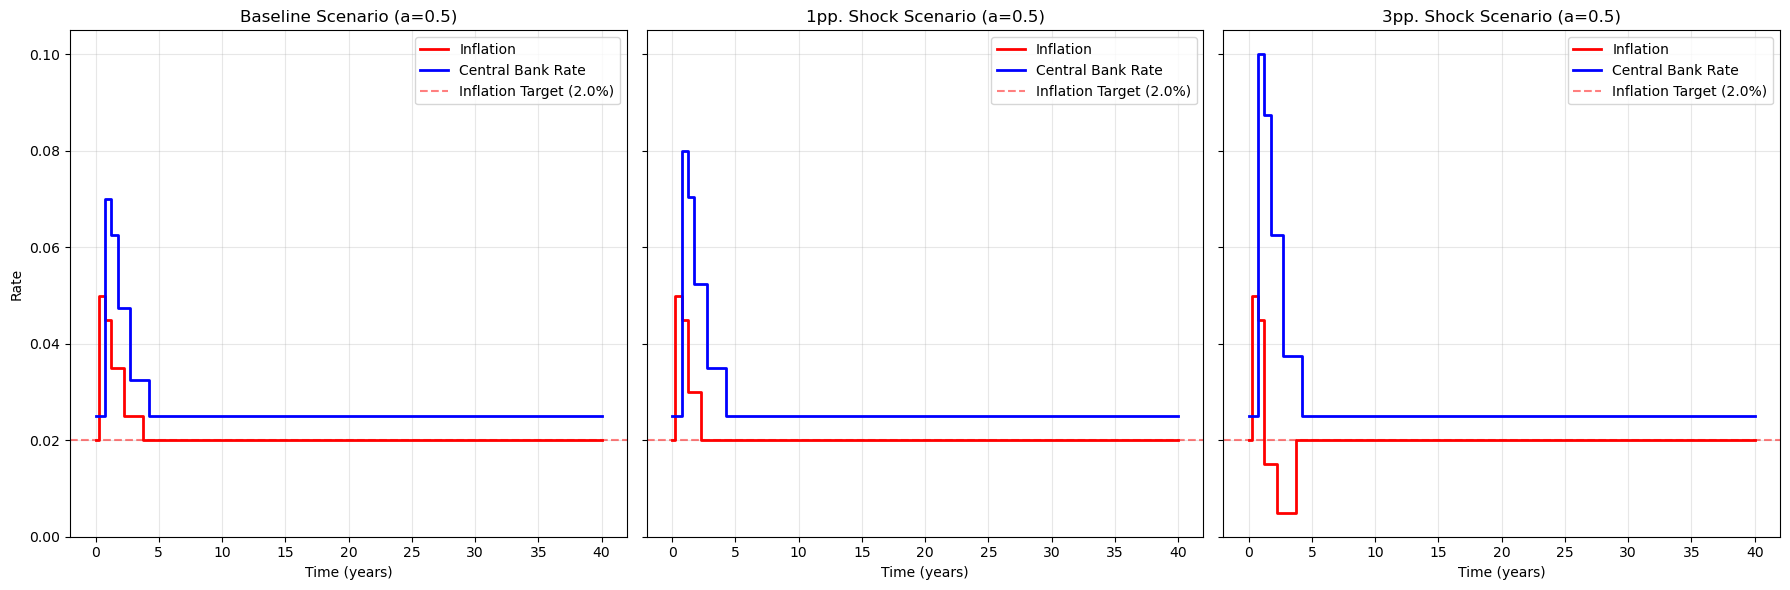

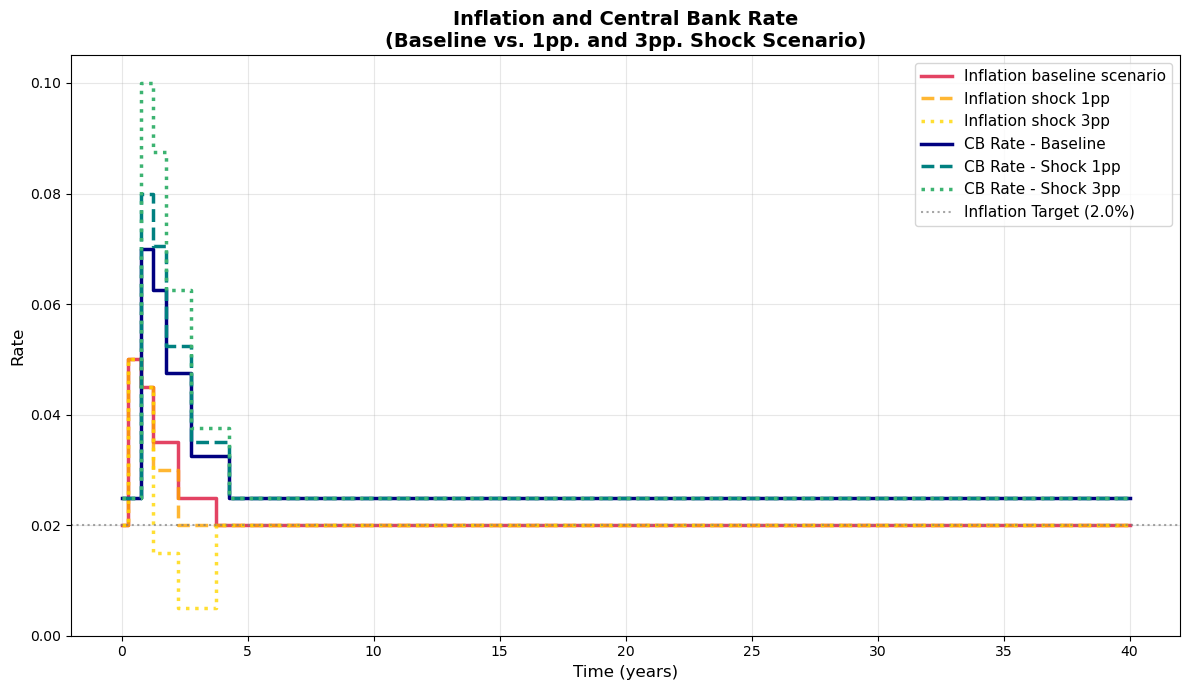

In [101]:
# Plots for scenarios 

# Plot for Dovish and Shock scenarios only
# Create time grid
dt = 1.0 / steps_per_year
time_grid = np.arange(max(len(inflation_baseline), len(inflation_shock_1pp), len(inflation_shock_3pp))) * dt

# Plot Dovish and Shock scenarios side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Baseline scenario
axs[0].step(time_grid[:len(inflation_baseline)], inflation_baseline, 
                        label='Inflation', color='red', linewidth=2, where='post')
axs[0].step(time_grid[:len(CB_path_baseline)], CB_path_baseline, 
                        label='Central Bank Rate', color='blue', linewidth=2, where='post')
axs[0].axhline(y=baseline_params.pi_star, color='red', linestyle='--', alpha=0.5, 
                           label=f'Inflation Target ({baseline_params.pi_star:.1%})')
axs[0].set_xlabel('Time (years)')
axs[0].set_ylabel('Rate')
axs[0].set_title(f'Baseline Scenario (a={baseline_params.a})')
axs[0].legend()
axs[0].grid(True, alpha=0.3)
axs[0].set_ylim(bottom=0)

# 1pp. shock scenario
axs[1].step(time_grid[:len(inflation_shock_1pp)], inflation_shock_1pp, 
                        label='Inflation', color='red', linewidth=2, where='post')
axs[1].step(time_grid[:len(CB_path_shock_1pp)], CB_path_shock_1pp, 
                        label='Central Bank Rate', color='blue', linewidth=2, where='post')
axs[1].axhline(y=shock_params.pi_star, color='red', linestyle='--', alpha=0.5, 
                           label=f'Inflation Target ({shock_params.pi_star:.1%})')
axs[1].set_xlabel('Time (years)')
axs[1].set_title(f'1pp. Shock Scenario (a={shock_params.a})')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# 3pp. shock scenario
axs[2].step(time_grid[:len(inflation_shock_3pp)], inflation_shock_3pp, 
                        label='Inflation', color='red', linewidth=2, where='post')
axs[2].step(time_grid[:len(CB_path_shock_3pp)], CB_path_shock_3pp, 
                        label='Central Bank Rate', color='blue', linewidth=2, where='post')
axs[2].axhline(y=shock_params.pi_star, color='red', linestyle='--', alpha=0.5, 
                           label=f'Inflation Target ({shock_params.pi_star:.1%})')
axs[2].set_xlabel('Time (years)')
axs[2].set_title(f'3pp. Shock Scenario (a={shock_params.a})')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

# Show full CB rate range in shock scenario
axs[1].set_ylim(bottom=0, top=np.max(CB_path_shock_3pp) * 1.05)

plt.tight_layout()
plt.show()

# Plot for Baseline (Dovish) vs. Shock scenario
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Plot the baseline inflation rate
ax.step(time_grid[:len(inflation_baseline)], inflation_baseline, 
                label='Inflation baseline scenario', color='crimson', linewidth=2.5, alpha=0.8, linestyle='-', where='post')

# Plot the 1pp. shock inflation rate
ax.step(time_grid[:len(inflation_shock_1pp)], inflation_shock_1pp, 
                label='Inflation shock 1pp', color='orange', linewidth=2.5, alpha=0.8, linestyle='--', where='post')

# Plot the 3pp. shock inflation rate
ax.step(time_grid[:len(inflation_shock_3pp)], inflation_shock_3pp, 
                label='Inflation shock 3pp', color='gold', linewidth=2.5, alpha=0.8, linestyle=':', where='post')

# Plot both central bank rate responses
ax.step(time_grid[:len(CB_path_baseline)], CB_path_baseline, 
                label='CB Rate - Baseline', color='navy', linewidth=2.5, linestyle='-', where='post')
ax.step(time_grid[:len(CB_path_shock_1pp)], CB_path_shock_1pp, 
                label='CB Rate - Shock 1pp', color='teal', linewidth=2.5, linestyle='--', where='post')
ax.step(time_grid[:len(CB_path_shock_3pp)], CB_path_shock_3pp, 
                label='CB Rate - Shock 3pp', color='mediumseagreen', linewidth=2.5, linestyle=':', where='post')

# Add inflation target line
ax.axhline(y=baseline_params.pi_star, color='gray', linestyle=':', alpha=0.7, linewidth=1.5,
                   label=f'Inflation Target ({baseline_params.pi_star:.1%})')

# Formatting
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Rate', fontsize=12)
ax.set_title('Inflation and Central Bank Rate\n(Baseline vs. 1pp. and 3pp. Shock Scenario)', 
                         fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
# Show full CB rate range in shock scenario
ax.set_ylim(bottom=0, top=np.max(CB_path_shock_3pp) * 1.05)

# Set appropriate y-limits to show all data
max_rate = max(np.max(CB_path_baseline), np.max(CB_path_shock_1pp), np.max(CB_path_shock_3pp), np.max(inflation_baseline))
ax.set_ylim(bottom=0, top=max_rate * 1.05)

plt.tight_layout()
plt.show()


In [102]:
# Calculate yield curves for baseline and shock scenarios

num_simulations = 30000000 # Number of Simulations

yield_curve_baseline = m.yield_curve_variable_steps(
    CB_path=CB_path_baseline,
    time_horizon=40,
    transition_year=15,
    number_of_simulations=num_simulations
)
print(f"Yield curve baseline calculated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

yield_curve_shock_1pp = m.yield_curve_variable_steps(
    CB_path=CB_path_shock_1pp,
    time_horizon=40,
    transition_year=15,
    number_of_simulations=num_simulations
)
print(f"Yield curve 1pp shock calculated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

yield_curve_shock_3pp = m.yield_curve_variable_steps(
    CB_path=CB_path_shock_3pp,
    time_horizon=40,
    transition_year=15,
    number_of_simulations=num_simulations
)
print(f"Yield curve 3pp shock calculated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Yield curve baseline calculated at: 2025-08-22 21:47:29
Yield curve 1pp shock calculated at: 2025-08-23 02:05:02
Yield curve 3pp shock calculated at: 2025-08-23 06:21:55


In [103]:
"""# Calculate yield curves for baseline and shock scenarios

num_simulations = 30000000 # Number of Simulations

yield_curve_baseline = m.yield_curve(
    CB_path=CB_path_baseline,
    time_horizon=40,
    steps_per_year=steps_per_year,
    number_of_simulations=num_simulations  
print(f"Yield curve baseline calculated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

yield_curve_shock_1pp = m.yield_curve(
    CB_path=CB_path_shock_1pp,
    time_horizon=40,
    steps_per_year=steps_per_year,
    number_of_simulations=num_simulations 
)
print(f"Yield curve 1ppshock calculated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

yield_curve_shock_3pp = m.yield_curve(
    CB_path=CB_path_shock_3pp,
    time_horizon=40,
    steps_per_year=steps_per_year,
    number_of_simulations=num_simulations 
)
print(f"Yield curve 3pp shock calculated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")"""

'# Calculate yield curves for baseline and shock scenarios\n\nnum_simulations = 30000000 # Number of Simulations\n\nyield_curve_baseline = m.yield_curve(\n    CB_path=CB_path_baseline,\n    time_horizon=40,\n    steps_per_year=steps_per_year,\n    number_of_simulations=num_simulations  \nprint(f"Yield curve baseline calculated at: {datetime.now().strftime(\'%Y-%m-%d %H:%M:%S\')}")\n\nyield_curve_shock_1pp = m.yield_curve(\n    CB_path=CB_path_shock_1pp,\n    time_horizon=40,\n    steps_per_year=steps_per_year,\n    number_of_simulations=num_simulations \n)\nprint(f"Yield curve 1ppshock calculated at: {datetime.now().strftime(\'%Y-%m-%d %H:%M:%S\')}")\n\nyield_curve_shock_3pp = m.yield_curve(\n    CB_path=CB_path_shock_3pp,\n    time_horizon=40,\n    steps_per_year=steps_per_year,\n    number_of_simulations=num_simulations \n)\nprint(f"Yield curve 3pp shock calculated at: {datetime.now().strftime(\'%Y-%m-%d %H:%M:%S\')}")'

In [ ]:
filename = os.path.join(os.getcwd(), f"yield_curve_info_seed{seed_number}.pkl")

yield_curve_info = {
    "years": time_grid,
    "yield_curve_baseline": yield_curve_baseline,
    "yield_curve_shock_1pp": yield_curve_shock_1pp,
    "yield_curve_shock_3pp": yield_curve_shock_3pp,
    "inflation_baseline": inflation_baseline,
    "inflation_shock_1pp": inflation_shock_1pp,
    "inflation_shock_3pp": inflation_shock_3pp,
    "tg_baseline": tg_baseline,
    "tg_shock_1pp": tg_shock_1pp,
    "tg_shock_3pp": tg_shock_3pp,

    "yield_table": yield_table,
    "target_years": target_years,
    "indices_found": indices_found,
    "sigma": sigma,
    "seed_number": seed_number,
    "num_simulations": num_simulations
}

with open(filename, "wb") as f:
    pickle.dump(yield_curve_info, f)


In [105]:
# Import yield curve data 

#with open(filename, "rb") as f:
#    loaded_yield_curve_info = pickle.load(f)

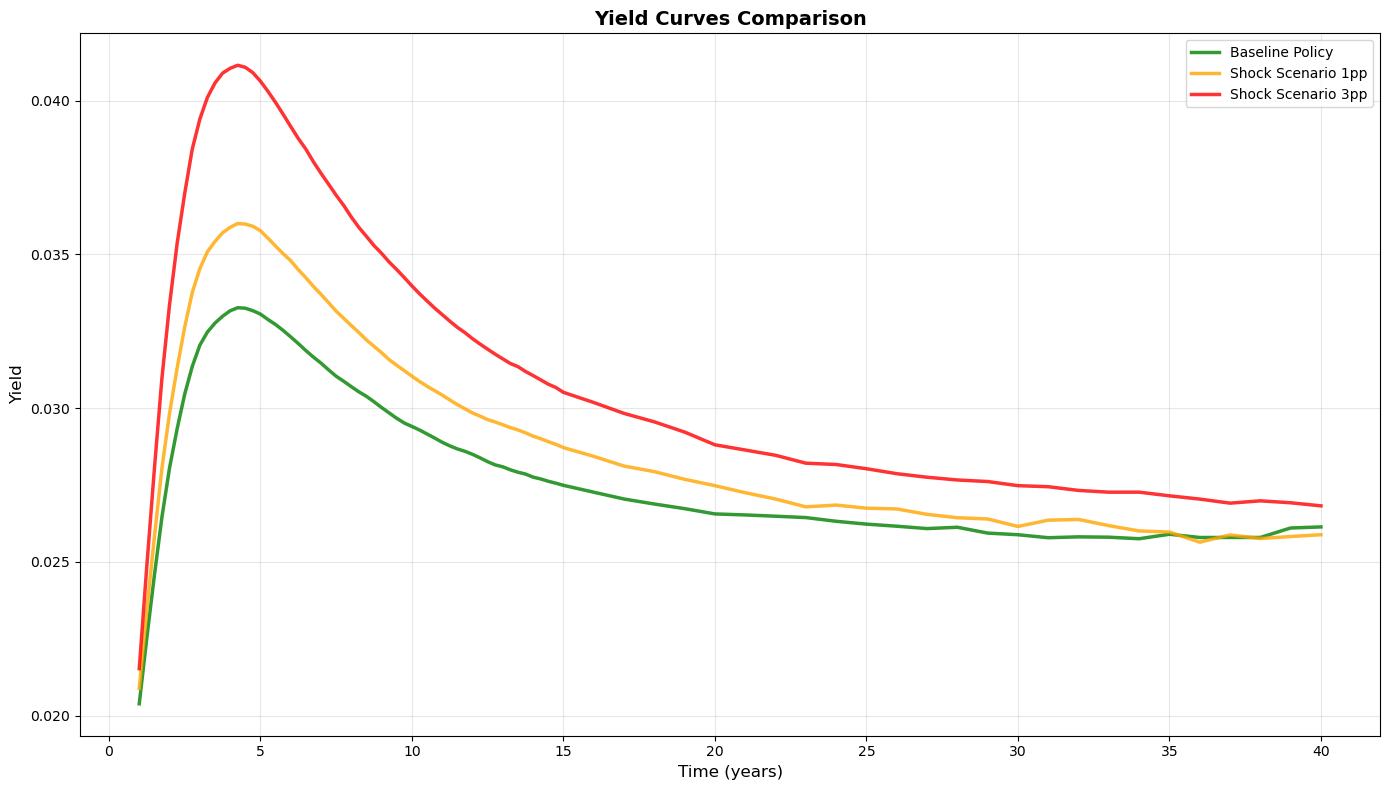

In [106]:
# Unpack yield curves and time grids
yc_baseline, tg_baseline = yield_curve_baseline
yc_shock_1pp, tg_shock_1pp = yield_curve_shock_1pp
yc_shock_3pp, tg_shock_3pp = yield_curve_shock_3pp

plt.figure(figsize=(14, 8))

# Baseline Scenario
plt.plot(tg_baseline[4:], yc_baseline[4:], 
         label='Baseline Policy', linewidth=2.5, color='green', alpha=0.8)

# Shock Scenarios
plt.plot(tg_shock_1pp[4:], yc_shock_1pp[4:], 
         label='Shock Scenario 1pp', linewidth=2.5, color='orange', alpha=0.8)
plt.plot(tg_shock_3pp[4:], yc_shock_3pp[4:], 
         label='Shock Scenario 3pp', linewidth=2.5, color='red', alpha=0.8)

plt.xlabel('Time (years)', fontsize=12)
plt.ylabel('Yield', fontsize=12)
plt.title('Yield Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [107]:
"""# Plot Baseline and Shock 

# create time grid 
actual_length = len(yield_curve_baseline) 
dt = 1.0 / steps_per_year  
time_grid = np.arange(actual_length) * dt

plt.figure(figsize=(14, 8))

# Baseline Szenario  
plt.plot(time_grid[4:], yield_curve_baseline[4:], 
         label='Baseline Policy', linewidth=2.5, color='green', alpha=0.8)

# Shock Szenario
plt.plot(time_grid[4:], yield_curve_shock_1pp[4:], 
         label='Shock Scenario', linewidth=2.5, color='orange', alpha=0.8)
plt.plot(time_grid[4:], yield_curve_shock_3pp[4:], 
         label='Shock Scenario 3pp', linewidth=2.5, color='red', alpha=0.8)

plt.xlabel('Time (years)', fontsize=12)
plt.ylabel('Yield', fontsize=12)
plt.title(f'Yield Curves Comparison', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()"""


"# Plot Baseline and Shock \n\n# create time grid \nactual_length = len(yield_curve_baseline) \ndt = 1.0 / steps_per_year  \ntime_grid = np.arange(actual_length) * dt\n\nplt.figure(figsize=(14, 8))\n\n# Baseline Szenario  \nplt.plot(time_grid[4:], yield_curve_baseline[4:], \n         label='Baseline Policy', linewidth=2.5, color='green', alpha=0.8)\n\n# Shock Szenario\nplt.plot(time_grid[4:], yield_curve_shock_1pp[4:], \n         label='Shock Scenario', linewidth=2.5, color='orange', alpha=0.8)\nplt.plot(time_grid[4:], yield_curve_shock_3pp[4:], \n         label='Shock Scenario 3pp', linewidth=2.5, color='red', alpha=0.8)\n\nplt.xlabel('Time (years)', fontsize=12)\nplt.ylabel('Yield', fontsize=12)\nplt.title(f'Yield Curves Comparison', \n          fontsize=14, fontweight='bold')\nplt.legend(fontsize=10, loc='best')\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()"

In [108]:
"""# Real yield curves

# Hawkish scenario
average_inflation_hawkish = np.zeros(T + 1)
for i in range(1, T + 1):
    average_inflation_hawkish[i] = np.mean(inflation_hawkish[:i + 1])
real_yield_curve_hawkish = yield_curve_hawkish[:len(average_inflation_hawkish)] - average_inflation_hawkish

# Doveish scenario
average_inflation_dovish = np.zeros(T + 1)
for i in range(1, T + 1):
    average_inflation_dovish[i] = np.mean(inflation_dovish[:i + 1])
real_yield_curve_dovish = yield_curve_dovish[:len(average_inflation_dovish)] - average_inflation_dovish

# Shock scenario
average_inflation_shock = np.zeros(T + 1)
for i in range(1, T + 1):
    average_inflation_shock[i] = np.mean(inflation_shock[:i + 1])
real_yield_curve_shock = yield_curve_shock[:len(average_inflation_shock)] - average_inflation_shock"""


'# Real yield curves\n\n# Hawkish scenario\naverage_inflation_hawkish = np.zeros(T + 1)\nfor i in range(1, T + 1):\n    average_inflation_hawkish[i] = np.mean(inflation_hawkish[:i + 1])\nreal_yield_curve_hawkish = yield_curve_hawkish[:len(average_inflation_hawkish)] - average_inflation_hawkish\n\n# Doveish scenario\naverage_inflation_dovish = np.zeros(T + 1)\nfor i in range(1, T + 1):\n    average_inflation_dovish[i] = np.mean(inflation_dovish[:i + 1])\nreal_yield_curve_dovish = yield_curve_dovish[:len(average_inflation_dovish)] - average_inflation_dovish\n\n# Shock scenario\naverage_inflation_shock = np.zeros(T + 1)\nfor i in range(1, T + 1):\n    average_inflation_shock[i] = np.mean(inflation_shock[:i + 1])\nreal_yield_curve_shock = yield_curve_shock[:len(average_inflation_shock)] - average_inflation_shock'

In [109]:
# Unpack yield curves and time grids
yc_baseline, tg_baseline = yield_curve_baseline
yc_shock_1pp, tg_shock_1pp = yield_curve_shock_1pp
yc_shock_3pp, tg_shock_3pp = yield_curve_shock_3pp

# Doveish scenario
average_inflation_baseline = np.zeros(len(yc_baseline))
for i in range(1, len(yc_baseline)):
    average_inflation_baseline[i] = np.mean(inflation_baseline[:i + 1])
real_yield_curve_baseline = yc_baseline[:len(average_inflation_baseline)] - average_inflation_baseline

# Shock scenario 1pp
average_inflation_shock_1pp = np.zeros(len(yc_shock_1pp))
for i in range(1, len(yc_shock_1pp)):
    average_inflation_shock_1pp[i] = np.mean(inflation_shock_1pp[:i + 1])
real_yield_curve_shock_1pp = yc_shock_1pp[:len(average_inflation_shock_1pp)] - average_inflation_shock_1pp

# Shock scenario 3pp
average_inflation_shock_3pp = np.zeros(len(yc_shock_3pp))
for i in range(1, len(yc_shock_3pp)):
    average_inflation_shock_3pp[i] = np.mean(inflation_shock_3pp[:i + 1])
real_yield_curve_shock_3pp = yc_shock_3pp[:len(average_inflation_shock_3pp)] - average_inflation_shock_3pp

# add smoothing 
sigma = 5  # adjustable smoothing parameter

# Apply Gaussian smoothing zu den Hauptkurven (ab Index 1)
real_yield_baseline_smoothed = gaussian_filter1d(real_yield_curve_baseline[1:], sigma=sigma)
real_yield_shock_1pp_smoothed = gaussian_filter1d(real_yield_curve_shock_1pp[1:], sigma=sigma)
real_yield_shock_3pp_smoothed = gaussian_filter1d(real_yield_curve_shock_3pp[1:], sigma=sigma)


In [110]:
"""# Real yield curves

# Doveish scenario
average_inflation_baseline = np.zeros(T + 1)
for i in range(1, T + 1):
    average_inflation_baseline[i] = np.mean(inflation_baseline[:i + 1])
real_yield_curve_baseline = yield_curve_baseline[:len(average_inflation_baseline)] - average_inflation_baseline

# Shock scenario
average_inflation_shock_1pp = np.zeros(T + 1)
for i in range(1, T + 1):
    average_inflation_shock_1pp[i] = np.mean(inflation_shock_1pp[:i + 1])
real_yield_curve_shock_1pp = yield_curve_shock_1pp[:len(average_inflation_shock_1pp)] - average_inflation_shock_1pp

average_inflation_shock_3pp = np.zeros(T + 1)
for i in range(1, T + 1):
    average_inflation_shock_3pp[i] = np.mean(inflation_shock_3pp[:i + 1])
real_yield_curve_shock_3pp = yield_curve_shock_3pp[:len(average_inflation_shock_3pp)] - average_inflation_shock_3pp

# add smoothing 
sigma = 5  # adjustable smoothing parameter

# Apply Gaussian smoothing zu den Hauptkurven (ab Index 1)
real_yield_baseline_smoothed = gaussian_filter1d(real_yield_curve_baseline[1:], sigma=sigma)
real_yield_shock_1pp_smoothed = gaussian_filter1d(real_yield_curve_shock_1pp[1:], sigma=sigma)
real_yield_shock_3pp_smoothed = gaussian_filter1d(real_yield_curve_shock_3pp[1:], sigma=sigma)
"""

'# Real yield curves\n\n# Doveish scenario\naverage_inflation_baseline = np.zeros(T + 1)\nfor i in range(1, T + 1):\n    average_inflation_baseline[i] = np.mean(inflation_baseline[:i + 1])\nreal_yield_curve_baseline = yield_curve_baseline[:len(average_inflation_baseline)] - average_inflation_baseline\n\n# Shock scenario\naverage_inflation_shock_1pp = np.zeros(T + 1)\nfor i in range(1, T + 1):\n    average_inflation_shock_1pp[i] = np.mean(inflation_shock_1pp[:i + 1])\nreal_yield_curve_shock_1pp = yield_curve_shock_1pp[:len(average_inflation_shock_1pp)] - average_inflation_shock_1pp\n\naverage_inflation_shock_3pp = np.zeros(T + 1)\nfor i in range(1, T + 1):\n    average_inflation_shock_3pp[i] = np.mean(inflation_shock_3pp[:i + 1])\nreal_yield_curve_shock_3pp = yield_curve_shock_3pp[:len(average_inflation_shock_3pp)] - average_inflation_shock_3pp\n\n# add smoothing \nsigma = 5  # adjustable smoothing parameter\n\n# Apply Gaussian smoothing zu den Hauptkurven (ab Index 1)\nreal_yield_basel

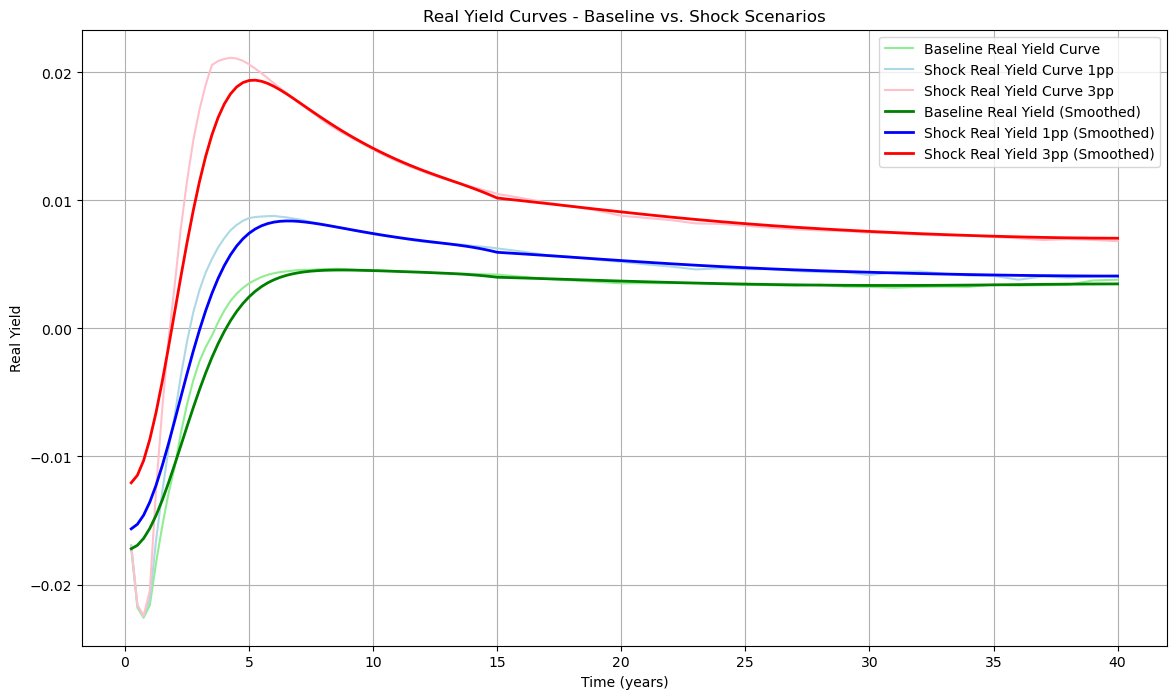

In [111]:
# Plot for both Real Yield curves
plt.figure(figsize=(14, 8))

# Create correct time grids for each curve length
dt = 1.0 / steps_per_year

# Plot unsmoothed curves in lighter shades
# Plot unsmoothed curves in lighter shades using correct time grids
plt.plot(tg_baseline[1:], real_yield_curve_baseline[1:], label='Baseline Real Yield Curve', color='lightgreen', alpha=1.0)
plt.plot(tg_shock_1pp[1:], real_yield_curve_shock_1pp[1:], label='Shock Real Yield Curve 1pp', color='lightblue', alpha=1.0)
plt.plot(tg_shock_3pp[1:], real_yield_curve_shock_3pp[1:], label='Shock Real Yield Curve 3pp', color='pink', alpha=1.0)

# Plot smoothed curves in darker shades using correct time grids
plt.plot(tg_baseline[1:], real_yield_baseline_smoothed, label='Baseline Real Yield (Smoothed)', color='green', linewidth=2)
plt.plot(tg_shock_1pp[1:], real_yield_shock_1pp_smoothed, label='Shock Real Yield 1pp (Smoothed)', color='blue', linewidth=2)
plt.plot(tg_shock_3pp[1:], real_yield_shock_3pp_smoothed, label='Shock Real Yield 3pp (Smoothed)', color='red', linewidth=2)
plt.xlabel('Time (years)')
plt.ylabel('Real Yield')
plt.title('Real Yield Curves - Baseline vs. Shock Scenarios')
plt.legend()
plt.grid(True)

plt.savefig(f"real_yield_curves_seed{seed_number}_{num_simulations}simulations.png", dpi=300, bbox_inches='tight')
plt.show()

In [112]:
"""# Plot for both Real Yield curves
plt.figure(figsize=(14, 8))

# Create correct time grids for each curve length
dt = 1.0 / steps_per_year

# Plot unsmoothed curves in lighter shades
# Plot unsmoothed curves in darker shades
plt.plot(time_grid[1:len(real_yield_curve_baseline)], real_yield_curve_baseline[1:], label='Baseline Real Yield Curve', color='lightcoral', alpha=1.0)
plt.plot(time_grid[1:len(real_yield_curve_shock_1pp)], real_yield_curve_shock_1pp[1:], label='Shock Real Yield Curve 1pp', color='lightblue', alpha=1.0)
plt.plot(time_grid[1:len(real_yield_curve_shock_3pp)], real_yield_curve_shock_3pp[1:], label='Shock Real Yield Curve 3pp', color='lightgreen', alpha=1.0)

# Plot smoothed curves in lighter shades
plt.plot(time_grid[1:len(real_yield_baseline_smoothed)+1], real_yield_baseline_smoothed, label='Baseline Real Yield (Smoothed)', color='blue', linewidth=2)
plt.plot(time_grid[1:len(real_yield_shock_1pp_smoothed)+1], real_yield_shock_1pp_smoothed, label='Shock Real Yield 1pp (Smoothed)', color='green', linewidth=2)
plt.plot(time_grid[1:len(real_yield_shock_3pp_smoothed)+1], real_yield_shock_3pp_smoothed, label='Shock Real Yield 3pp (Smoothed)', color='red', linewidth=2)
plt.xlabel('Time (years)')
plt.ylabel('Real Yield')
plt.title('Real Yield Curves - Baseline vs. Shock Scenarios')
plt.legend()
plt.grid(True)

plt.savefig(f"real_yield_curves_seed{seed_number}_{num_simulations}simulations.png", dpi=300, bbox_inches='tight')
plt.show()"""

'# Plot for both Real Yield curves\nplt.figure(figsize=(14, 8))\n\n# Create correct time grids for each curve length\ndt = 1.0 / steps_per_year\n\n# Plot unsmoothed curves in lighter shades\n# Plot unsmoothed curves in darker shades\nplt.plot(time_grid[1:len(real_yield_curve_baseline)], real_yield_curve_baseline[1:], label=\'Baseline Real Yield Curve\', color=\'lightcoral\', alpha=1.0)\nplt.plot(time_grid[1:len(real_yield_curve_shock_1pp)], real_yield_curve_shock_1pp[1:], label=\'Shock Real Yield Curve 1pp\', color=\'lightblue\', alpha=1.0)\nplt.plot(time_grid[1:len(real_yield_curve_shock_3pp)], real_yield_curve_shock_3pp[1:], label=\'Shock Real Yield Curve 3pp\', color=\'lightgreen\', alpha=1.0)\n\n# Plot smoothed curves in lighter shades\nplt.plot(time_grid[1:len(real_yield_baseline_smoothed)+1], real_yield_baseline_smoothed, label=\'Baseline Real Yield (Smoothed)\', color=\'blue\', linewidth=2)\nplt.plot(time_grid[1:len(real_yield_shock_1pp_smoothed)+1], real_yield_shock_1pp_smoothe

In the study, we are interessted in long-term yields for 20, 25, 30 and 40 years. For that, we have to find out the corresponding indices. 

In [113]:
# Find the indices for the targeted years using the correct time grid
target_years = [10, 20, 25, 30, 40]

def find_time_index(target_year, time_grid):
    """Find the time index that corresponds closest to the target year"""
    differences = np.abs(time_grid - target_year)
    closest_index = np.argmin(differences)
    actual_time = time_grid[closest_index]
    return closest_index, actual_time

print("Time Index Lookup for Specific Years")
print("=" * 50)
print(f"{'Target Year':<12} {'Time Index':<12} {'Actual Time':<12} {'Difference':<12}")
print("-" * 50)

# Use tg_baseline for lookup
indices_found = {}
for year in target_years:
    index, actual_time = find_time_index(year, tg_baseline)
    difference = abs(actual_time - year)
    indices_found[year] = index
    
    print(f"{year:<12} {index:<12} {actual_time:<12.3f} {difference:<12.3f}")

print("\n" + "=" * 50)
print("Summary for easy reference:")
for year in target_years:
    print(f"Year {year}: tg_baseline[{indices_found[year]}]")

Time Index Lookup for Specific Years
Target Year  Time Index   Actual Time  Difference  
--------------------------------------------------
10           40           10.000       0.000       
20           65           20.000       0.000       
25           70           25.000       0.000       
30           75           30.000       0.000       
40           85           40.000       0.000       

Summary for easy reference:
Year 10: tg_baseline[40]
Year 20: tg_baseline[65]
Year 25: tg_baseline[70]
Year 30: tg_baseline[75]
Year 40: tg_baseline[85]


In [114]:
"""# Find the indices for the targeted years
target_years = [20, 40, 30, 25]

def find_time_index(target_year, time_grid):
    # Find the time index that corresponds closest to the target year
    differences = np.abs(time_grid - target_year)
    closest_index = np.argmin(differences)
    actual_time = time_grid[closest_index]
    return closest_index, actual_time

print("Time Index Lookup for Specific Years")
print("=" * 50)
print(f"{'Target Year':<12} {'Time Index':<12} {'Actual Time':<12} {'Difference':<12}")
print("-" * 50)

# Find indices for each target year
indices_found = {}
for year in target_years:
    index, actual_time = find_time_index(year, time_grid)
    difference = abs(actual_time - year)
    indices_found[year] = index
    
    print(f"{year:<12} {index:<12} {actual_time:<12.3f} {difference:<12.3f}")

print("\n" + "=" * 50)
print("Summary for easy reference:")
for year in target_years:
    print(f"Year {year}: time_grid[{indices_found[year]}]")"""


'# Find the indices for the targeted years\ntarget_years = [20, 40, 30, 25]\n\ndef find_time_index(target_year, time_grid):\n    # Find the time index that corresponds closest to the target year\n    differences = np.abs(time_grid - target_year)\n    closest_index = np.argmin(differences)\n    actual_time = time_grid[closest_index]\n    return closest_index, actual_time\n\nprint("Time Index Lookup for Specific Years")\nprint("=" * 50)\nprint(f"{\'Target Year\':<12} {\'Time Index\':<12} {\'Actual Time\':<12} {\'Difference\':<12}")\nprint("-" * 50)\n\n# Find indices for each target year\nindices_found = {}\nfor year in target_years:\n    index, actual_time = find_time_index(year, time_grid)\n    difference = abs(actual_time - year)\n    indices_found[year] = index\n    \n    print(f"{year:<12} {index:<12} {actual_time:<12.3f} {difference:<12.3f}")\n\nprint("\n" + "=" * 50)\nprint("Summary for easy reference:")\nfor year in target_years:\n    print(f"Year {year}: time_grid[{indices_found[

In [115]:
# Create Real Yields Table for all target years using tg_baseline

indices_found = {}
for year in target_years:
    index, actual_time = find_time_index(year, tg_baseline)
    indices_found[year] = index

table_data = []

for year in target_years:
    time_idx = indices_found[year]
    baseline_yield = real_yield_curve_baseline[time_idx] * 100
    shock_yield_1pp = real_yield_curve_shock_1pp[time_idx] * 100
    shock_yield_3pp = real_yield_curve_shock_3pp[time_idx] * 100

    table_data.append({
        'Year': year,
        'Time Index': time_idx,
        'Time (years)': tg_baseline[time_idx],
        'Baseline Real Yield (%)': round(baseline_yield, 2),
        '1pp Shock Real Yield (%)': round(shock_yield_1pp, 2),
        '3pp Shock Real Yield (%)': round(shock_yield_3pp, 2),
        'Baseline Real Yield (Smoothed, %)': round(real_yield_baseline_smoothed[time_idx-1]*100, 2),
        '1pp Shock Real Yield (Smoothed, %)': round(real_yield_shock_1pp_smoothed[time_idx-1]*100, 2),
        '3pp Shock Real Yield (Smoothed, %)': round(real_yield_shock_3pp_smoothed[time_idx-1]*100, 2),
    })

yield_table = pd.DataFrame(table_data)

# Display the table
print("Real Yield Curves at Different Time Points")
print("=" * 60)
print(yield_table.to_string(index=False))

Real Yield Curves at Different Time Points
 Year  Time Index  Time (years)  Baseline Real Yield (%)  1pp Shock Real Yield (%)  3pp Shock Real Yield (%)  Baseline Real Yield (Smoothed, %)  1pp Shock Real Yield (Smoothed, %)  3pp Shock Real Yield (Smoothed, %)
   10          40          10.0                     0.45                      0.74                      1.40                               0.45                                0.74                                1.41
   20          65          20.0                     0.35                      0.52                      0.88                               0.37                                0.53                                0.91
   25          70          25.0                     0.34                      0.46                      0.80                               0.35                                0.47                                0.82
   30          75          30.0                     0.32                      0.42           

In [116]:
"""# Create Real Yields Table 

# Use correct indices for years of interest

indices_found = {}
for year in target_years:
    index, actual_time = find_time_index(year, time_grid)
    indices_found[year] = index

# Create data for the table
table_data = []

for year in target_years:
    time_idx = indices_found[year]
    baseline_yield = real_yield_curve_baseline[time_idx] * 100
    shock_yield_1pp = real_yield_curve_shock_1pp[time_idx] * 100
    shock_yield_3pp = real_yield_curve_shock_3pp[time_idx] * 100

    table_data.append({
        'Year': year,
        'Time Index': time_idx,
        'Time (years)': time_grid[time_idx],
        'Baseline Real Yield (%)': round(baseline_yield, 2),
        '1pp Shock Real Yield (%)': round(shock_yield_1pp, 2),
        '3pp Shock Real Yield (%)': round(shock_yield_3pp, 2),
        'Baseline Real Yield (Smoothed, %)': round(real_yield_baseline_smoothed[time_idx-1]*100, 2),
        '1pp Shock Real Yield (Smoothed, %)': round(real_yield_shock_1pp_smoothed[time_idx-1]*100, 2),
        '3pp Shock Real Yield (Smoothed, %)': round(real_yield_shock_3pp_smoothed[time_idx-1]*100, 2),
    })

# Create DataFrame
yield_table = pd.DataFrame(table_data)

# Display the table
print("Real Yield Curves at Different Time Points")
print("=" * 60)
print(yield_table.to_string(index=False))"""

'# Create Real Yields Table \n\n# Use correct indices for years of interest\n\nindices_found = {}\nfor year in target_years:\n    index, actual_time = find_time_index(year, time_grid)\n    indices_found[year] = index\n\n# Create data for the table\ntable_data = []\n\nfor year in target_years:\n    time_idx = indices_found[year]\n    baseline_yield = real_yield_curve_baseline[time_idx] * 100\n    shock_yield_1pp = real_yield_curve_shock_1pp[time_idx] * 100\n    shock_yield_3pp = real_yield_curve_shock_3pp[time_idx] * 100\n\n    table_data.append({\n        \'Year\': year,\n        \'Time Index\': time_idx,\n        \'Time (years)\': time_grid[time_idx],\n        \'Baseline Real Yield (%)\': round(baseline_yield, 2),\n        \'1pp Shock Real Yield (%)\': round(shock_yield_1pp, 2),\n        \'3pp Shock Real Yield (%)\': round(shock_yield_3pp, 2),\n        \'Baseline Real Yield (Smoothed, %)\': round(real_yield_baseline_smoothed[time_idx-1]*100, 2),\n        \'1pp Shock Real Yield (Smooth

In [117]:
# Create Real Yields Table 

# Use correct indices for years of interest (use tg_baseline for lookup)
indices_found = {}
for year in target_years:
    index, actual_time = find_time_index(year, tg_baseline)
    indices_found[year] = index

# Create data for the table
table_data = []

for year in target_years:
    time_idx = indices_found[year]
    baseline_yield = real_yield_curve_baseline[time_idx] * 100
    shock_yield_1pp = real_yield_curve_shock_1pp[time_idx] * 100
    shock_yield_3pp = real_yield_curve_shock_3pp[time_idx] * 100

    table_data.append({
        'Year': year,
        'Time Index': time_idx,
        'Time (years)': tg_baseline[time_idx],
        'Baseline Real Yield (%)': round(baseline_yield, 2),
        '1pp Shock Real Yield (%)': round(shock_yield_1pp, 2),
        '3pp Shock Real Yield (%)': round(shock_yield_3pp, 2),
        'Baseline Real Yield (Smoothed, %)': round(real_yield_baseline_smoothed[time_idx-1]*100, 2),
        '1pp Shock Real Yield (Smoothed, %)': round(real_yield_shock_1pp_smoothed[time_idx-1]*100, 2),
        '3pp Shock Real Yield (Smoothed, %)': round(real_yield_shock_3pp_smoothed[time_idx-1]*100, 2),
    })

# Create DataFrame
yield_table = pd.DataFrame(table_data)

# Display the table
print("Real Yield Curves at Different Time Points")
print("=" * 60)
print(yield_table.to_string(index=False))


Real Yield Curves at Different Time Points
 Year  Time Index  Time (years)  Baseline Real Yield (%)  1pp Shock Real Yield (%)  3pp Shock Real Yield (%)  Baseline Real Yield (Smoothed, %)  1pp Shock Real Yield (Smoothed, %)  3pp Shock Real Yield (Smoothed, %)
   10          40          10.0                     0.45                      0.74                      1.40                               0.45                                0.74                                1.41
   20          65          20.0                     0.35                      0.52                      0.88                               0.37                                0.53                                0.91
   25          70          25.0                     0.34                      0.46                      0.80                               0.35                                0.47                                0.82
   30          75          30.0                     0.32                      0.42           

In [119]:
import pickle

# Save all variables in the current namespace as a pickle file

variables_to_save = {
    'inflation_shock_3pp': inflation_shock_3pp,
    'inflation_shock_3pp_var': inflation_shock_3pp_var,
    'm': m,
    'max_rate': max_rate,
    'num_simulations': num_simulations,
    'output_gap_baseline': output_gap_baseline,
    'output_gap_baseline_var': output_gap_baseline_var,
    'output_gap_shock_1pp': output_gap_shock_1pp,
    'output_gap_shock_1pp_var': output_gap_shock_1pp_var,
    'output_gap_shock_3pp': output_gap_shock_3pp,
    'output_gap_shock_3pp_var': output_gap_shock_3pp_var,
    'r': r,
    'real_yield_baseline_smoothed': real_yield_baseline_smoothed,
    'real_yield_curve_baseline': real_yield_curve_baseline,
    'real_yield_curve_shock_1pp': real_yield_curve_shock_1pp,
    'real_yield_curve_shock_3pp': real_yield_curve_shock_3pp,
    'real_yield_shock_1pp_smoothed': real_yield_shock_1pp_smoothed,
    'real_yield_shock_3pp_smoothed': real_yield_shock_3pp_smoothed,
    'seed_number': seed_number,
    'shock_params': shock_params,
    'shock_yield_1pp': shock_yield_1pp,
    'shock_yield_3pp': shock_yield_3pp,
    'sigma': sigma,
    'steps_per_year': steps_per_year,
    'table_data': table_data,
    'target_years': target_years,
    'tg_baseline': tg_baseline,
    'tg_shock_1pp': tg_shock_1pp,
    'tg_shock_3pp': tg_shock_3pp,
    'time_grid': time_grid,
    'time_idx': time_idx,
    'transition_year': transition_year,
    'yc_baseline': yc_baseline,
    'yc_shock_1pp': yc_shock_1pp,
    'yc_shock_3pp': yc_shock_3pp,
    'year': year,
    'yield_curve': yield_curve,
    'yield_curve_baseline': yield_curve_baseline,
    'yield_curve_info': yield_curve_info,
    'yield_curve_shock_1pp': yield_curve_shock_1pp,
    'yield_curve_shock_3pp': yield_curve_shock_3pp,
    'yield_table': yield_table
}

with open(f"all_variables_seed{seed_number}_{num_simulations}simulations.pkl", "wb") as f:
    pickle.dump(variables_to_save, f)

In [118]:
# Save yield table as CSV
yield_table.to_csv(f'real_yields_seed{seed_number}_{num_simulations}simulations_excel.csv', index=False, sep=';', decimal=',')